# Preamble

This notebook shows the results of training with different data ranges. Due to past findings the prediction of the ai can be signifcantly better when trained on specific parts of the dataset. Here the ai has been trained on data within the range (distance) of 500 to the midpoint. 

# Preparation of data

## Setting up dataframe

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from typing import List
import os 
import sklearn.preprocessing

In [2]:
distance_threshold = 500
HEIGHT_CONSTANT = False
directory_path = '/Users/benedictkunzmann/Desktop/Bachelorarbeit/Verlauf/Modelle/20230902_version_3.1/01_measurement_data'

In [3]:
### function definition section:
def sort_key(file_path): # define a custom sorting key function to sort filenames alphabetically
    """ notes here """
    
    file_name = os.path.basename(file_path)
    
    return file_name

def get_csv_paths_list(directory_path: str):
    """ notes:
        this function is meant to list all A4T-, A5T-, A6T- and A7T-measurement files
         for different coil-coil-distances in form of her absolute filepathes."""

    csv_files = []

    parPath = os.getcwd()
    dataFolder = directory_path
    dataPath = os.path.join(parPath, dataFolder)

    subfolders = [f.path for f in os.scandir(dataPath) if f.is_dir()]

    for folder in subfolders:
        files_in_dir = glob.glob(os.path.join(folder, "*.csv"))
        sorted_files = sorted(files_in_dir, key=sort_key)
        csv_files.append(sorted_files)

    csv_files = csv_files[0:-1]

    return csv_files

def process_csv_files(csv_block: List[str]) -> pd.DataFrame:
    """ notes:
        parameter csv_block needs to be a list of 4 filepath strings.
        those strings refer to 4 different measurement files of sensors
         A4T, A5T, A6T and A7T.
        for a different height (coil-coil-distance) another csv_block
         has to be passed in.
        this function returns a combined/merged pd.dataframe in which
         the structure is ["A4T","A5T","A6T","A7T","x","y","z"], 
         thus all XxY-grids within each individual measurment file
         are flattened."""

    tmp_dfs = []
    columns = ["A4T","A5T","A6T","A7T","x","y","z"]
    merged_df = pd.DataFrame(columns=columns)

    curr_dz = float(csv_block[0].split("_dz")[1].split("/")[0]) # extract current z-height of dataset
    for _, sensor_file in enumerate(csv_block):
        data_list = [] # create a list to store the data

        curr_sensor = sensor_file.split("_")[-1].split(".")[0]  # extract current sensor's name in dataset

        df = pd.read_csv(sensor_file,skiprows=28,sep=",",index_col=0)
        df.index = pd.to_numeric(df.index)
        df.columns = pd.to_numeric(df.columns)

        for row_label, row in df.iterrows():
            for col_label, value in row.items():
                data_list.append((value, col_label, row_label, curr_dz, curr_sensor))

        tmp_dfs.append(pd.DataFrame(data_list, columns=["data","x","y","z","sensor"]))

        for _, tmp_df in enumerate(tmp_dfs):
            sensor_name = tmp_df["sensor"][0]
            merged_df[sensor_name] = tmp_df["data"]
        merged_df["x"] = tmp_df["x"]
        merged_df["y"] = tmp_df["y"]
        merged_df["z"] = tmp_df["z"]
        
    return merged_df

In [4]:
def extend_array(arr: np.ndarray, n: int):
    if arr.ndim == 1:
        result = []
        result.extend([arr[0]])
        for i in range(1, len(arr)):
            diff = (arr[i] - arr[i-1]) / (n+1)
            new_elements = [arr[i-1] + j*diff for j in range(1, (n+1))]
            result.extend(new_elements)
            result.extend([arr[i]])
        return np.array(result)

    result = []
    for row in arr:
        new_row = [row[0]]
        for i in range(1, len(row)):
            diff = (row[i] - row[i-1]) / (n+1)
            new_elements = [row[i-1] + j*diff for j in range(1, (n+1))]
            new_row.extend(new_elements)
            new_row.append(row[i])
        result.append(new_row)
    return np.array(result)

In [5]:
csv_files = []
merged_df_list = []

csv_files = get_csv_paths_list(directory_path) # function call to get the filepathes of all measurement files
csv_files # jupyter print

for idx, z_height_group in enumerate(csv_files): # loop through each group of files (A4T, A5T, A6T, A7T)
    merged_df_list.append(process_csv_files(z_height_group))

final_combined_df = pd.concat(merged_df_list, ignore_index=True)
final_combined_df

,A4T,A5T,A6T,A7T,x,y,z
0,0.122,0.159,0.161,0.148,620.0,-1120.0,190.0
1,0.160,0.194,0.192,0.173,600.0,-1120.0,190.0
2,0.145,0.186,0.189,0.178,580.0,-1120.0,190.0
3,0.132,0.167,0.168,0.154,560.0,-1120.0,190.0
4,0.132,0.167,0.172,0.161,540.0,-1120.0,190.0
...,...,...,...,...,...,...,...
49828,0.143,0.179,0.176,0.156,-540.0,1120.0,180.0
49829,0.110,0.151,0.143,0.128,-560.0,1120.0,180.0
49830,0.114,0.159,0.156,0.143,-580.0,1120.0,180.0
49831,0.157,0.192,0.187,0.167,-600.0,1120.0,180.0


In [6]:
print(final_combined_df["A4T"].max(), final_combined_df["A4T"].min())
print(final_combined_df["A5T"].max(), final_combined_df["A5T"].min())
print(final_combined_df["A6T"].max(), final_combined_df["A6T"].min())
print(final_combined_df["A7T"].max(), final_combined_df["A7T"].min())
print(final_combined_df["x"].max(), final_combined_df["x"].min())
print(final_combined_df["y"].max(), final_combined_df["y"].min())

3.934 0.0
3.632 0.0
3.481 0.0
3.983 0.0
620.0 -620.0
1120.0 -1120.0


In [7]:
import json

scaler_data = {
    "A4T_min" : final_combined_df["A4T"].min(),
    "A5T_min" : final_combined_df["A5T"].min(),
    "A6T_min" : final_combined_df["A6T"].min(),
    "A7T_min" : final_combined_df["A7T"].min(),
    "x_min" : final_combined_df["x"].min(),
    "y_min" : final_combined_df["y"].min(),
    "A4T_max" : final_combined_df["A4T"].max(),
    "A5T_max" : final_combined_df["A5T"].max(),
    "A6T_max" : final_combined_df["A6T"].max(),
    "A7T_max" : final_combined_df["A7T"].max(),
    "x_max" : final_combined_df["x"].max(),
    "y_max" : final_combined_df["y"].max(),
}

# Serialize data into file:
# json.dump(scaler_data, open(f"scaler_data_range_{distance_threshold}.json", 'w'))

## Creating a prescaler

In [8]:
prescaler_input_data = sklearn.preprocessing.MinMaxScaler()
prescaler_target_data = sklearn.preprocessing.MinMaxScaler()

prescaler_input_data.fit(final_combined_df[["A4T", "A5T", "A6T", "A7T"]])
prescaler_target_data.fit(final_combined_df[["x", "y"]])

MinMaxScaler()

In [9]:
prescaler_input_data.data_max_, prescaler_input_data.data_min_

(array([3.934, 3.632, 3.481, 3.983]), array([0., 0., 0., 0.]))

In [10]:
prescaler_target_data.data_max_, prescaler_target_data.data_min_

(array([ 620., 1120.]), array([ -620., -1120.]))

In [11]:
# import pickle

# with open('prescaler_input_data.pkl', 'wb') as file:
#     pickle.dump(prescaler_input_data, file)

# with open('prescaler_target_data.pkl', 'wb') as file:
#     pickle.dump(prescaler_target_data, file)

### Cuttting the Frame

In [12]:
# Calculate Euclidean distance
final_combined_df['distance'] = np.sqrt(final_combined_df['x']**2 + final_combined_df['y']**2)

# Filter the DataFrame based on the distance threshold
filtered_df = final_combined_df[final_combined_df['distance'] <= distance_threshold]

# Drop the 'distance' column if you don't need it anymore
filtered_df = filtered_df.drop(columns=['distance'])

# Display the filtered DataFrame
filtered_df

,A4T,A5T,A6T,A7T,x,y,z
1984,0.275,0.549,1.332,1.625,0.0,-500.0,190.0
2040,0.229,0.623,1.074,1.973,140.0,-480.0,190.0
2041,0.344,0.625,1.082,1.874,120.0,-480.0,190.0
2042,0.452,0.629,1.086,1.797,100.0,-480.0,190.0
2043,0.532,0.636,1.099,1.708,80.0,-480.0,190.0
...,...,...,...,...,...,...,...
47789,1.318,1.760,0.475,0.685,-80.0,480.0,180.0
47790,1.310,1.826,0.394,0.682,-100.0,480.0,180.0
47791,1.300,1.906,0.295,0.679,-120.0,480.0,180.0
47792,1.288,2.004,0.190,0.664,-140.0,480.0,180.0


In [13]:
# input_data = final_combined_df[["A4T", "A5T", "A6T", "A7T"]]
input_data = filtered_df[["A4T", "A5T", "A6T", "A7T"]]
input_data

,A4T,A5T,A6T,A7T
1984,0.275,0.549,1.332,1.625
2040,0.229,0.623,1.074,1.973
2041,0.344,0.625,1.082,1.874
2042,0.452,0.629,1.086,1.797
2043,0.532,0.636,1.099,1.708
...,...,...,...,...
47789,1.318,1.760,0.475,0.685
47790,1.310,1.826,0.394,0.682
47791,1.300,1.906,0.295,0.679
47792,1.288,2.004,0.190,0.664


In [14]:
# target_data = final_combined_df[["x", "y"]]
target_data = filtered_df[["x", "y"]]
target_data

,x,y
1984,0.0,-500.0
2040,140.0,-480.0
2041,120.0,-480.0
2042,100.0,-480.0
2043,80.0,-480.0
...,...,...
47789,-80.0,480.0
47790,-100.0,480.0
47791,-120.0,480.0
47792,-140.0,480.0


## Scale the dataframe

In [15]:
# scaler_input = sklearn.preprocessing.MinMaxScaler()
# scaled_input_data = scaler_input.fit_transform(input_data)
scaled_input_data = prescaler_input_data.transform(input_data)
scaled_input_data.max(axis=0)

array([1.        , 0.98678414, 0.95777076, 0.8850113 ])

In [16]:
# scaler_target = sklearn.preprocessing.MinMaxScaler()
# scaled_target_data = scaler_target.fit_transform(target_data)
scaled_target_data = prescaler_target_data.transform(target_data)
scaled_target_data.max(axis=0), scaled_target_data.min(axis=0)

(array([0.90322581, 0.72321429]), array([0.09677419, 0.27678571]))

## Get distribution of the datapoints

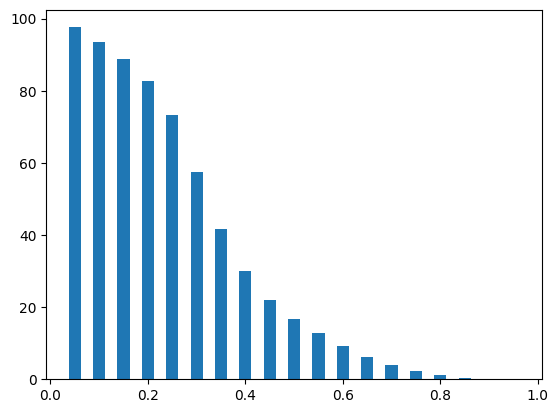

In [17]:
import matplotlib.pyplot as plt

percentages = []
thresholds = []

for threshold in np.arange(0.05, 1, 0.05):
    thresholds.append(threshold)
    filtered_arr = scaled_input_data[scaled_input_data >= threshold]
    percentage = len(filtered_arr) / scaled_input_data.size * 100
    percentages.append(percentage)
    # print(f"Threshold: {threshold:.2f}, Percentage: {percentage:.2f}%")

plt.bar(thresholds, percentages, width= 0.025)
plt.show()

# Model

In [18]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Input, Activation, Dense, BatchNormalization
from keras.initializers import HeUniform
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

In [19]:
import metrics
import datetime
import time

## Generating weights for training


In [24]:
# diff_from_1 = np.abs(0.5 - scaled_target_data)
diff_from_1 = np.linalg.norm(0.5 - scaled_target_data, axis=1)
# output_weights = 1 / (diff_from_1 + 1e-7) # 1e-7 to prevent "devided by zero error"
output_weights = np.exp(-(diff_from_1/0.6)**2)
# sample_weight_train /= np.sum(sample_weight_train) / len(sample_weight_train)

output_weights.min(), output_weights.max(), output_weights.shape

(0.6365821473333703, 1.0, (13727,))

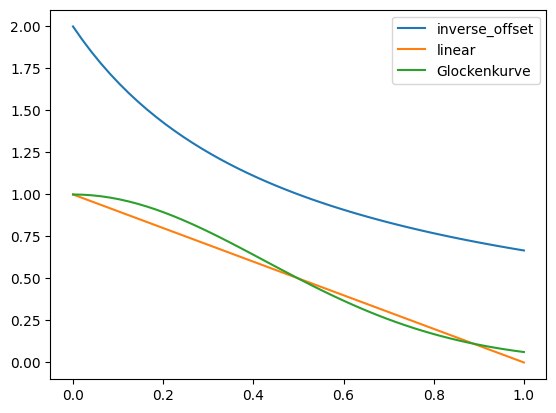

In [25]:
x = np.linspace(0, 1)
y = np.exp(-(x/0.6)**2)
# plt.plot(x, 1/x, label = "inverse")
plt.plot(x, 1/(x + 0.5), label = "inverse_offset")
plt.plot(x, 1-x, label = "linear")
plt.plot(x, y, label="Glockenkurve")
plt.legend()

In [26]:
x

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

## Building the model

In [28]:
n_hidden = 300
n_features = 4

model = Sequential()
model.add(Input(shape= (n_features), name='Dense_Input'))
model.add(Dense(n_hidden, kernel_initializer= HeUniform(), name='Dense_1'))
model.add(Activation('relu', name='relu_1'))
# model.add(Dropout(rate=0.2, name='dropout_1'))
# model.add(Dense(n_hidden, kernel_initializer= HeUniform(), name='Dense_2'))
# model.add(Activation('relu', name='relu_2'))
# model.add(Dropout(rate=0.2, name='dropout_2'))
model.add(BatchNormalization())
model.add(Dense(n_hidden, kernel_initializer= HeUniform(), name='Dense_4'))
model.add(Activation('relu', name='relu_4'))
model.add(BatchNormalization())
model.add(Dense(2, name='Dense_Out'))
model.add(Activation('sigmoid', name='sigmoid_Out'))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 300)               1500      
                                                                 
 relu_1 (Activation)         (None, 300)               0         
                                                                 
 batch_normalization (BatchN  (None, 300)              1200      
 ormalization)                                                   
                                                                 
 Dense_4 (Dense)             (None, 300)               90300     
                                                                 
 relu_4 (Activation)         (None, 300)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                      

## Training the model

In [30]:
import math
# Define configuration parameters
start_lr = 0.01
rampup_epochs = 40
exp_decay = 0.0075

# Define the scheduling function
def scheduler(epoch):
  def lr(epoch, start_lr, rampup_epochs, exp_decay):
    if epoch < rampup_epochs:
      return start_lr
    else:
      return start_lr * math.exp(-exp_decay * epoch)
  return lr(epoch, start_lr, rampup_epochs, exp_decay)


from keras.optimizers.schedules.learning_rate_schedule import ExponentialDecay

lr_scheduler = ExponentialDecay(
  initial_learning_rate= 0.01,
  decay_steps= 301 * 180,
  decay_rate= 0.96
)

In [31]:
# optimizer = Adam()
optimizer = Adam(learning_rate= lr_scheduler) # alternatic, dann learning_callback im fit() rausnehmen
loss = MeanSquaredError()

timestamp = time.time()
datetime_obj = datetime.datetime.fromtimestamp(timestamp)
# Format the datetime object as a string in your desired format
readable_time = datetime_obj.strftime('%Y-%m-%d%H:%M:%S')

mcp_save = ModelCheckpoint(f'trained_models/MLP-DataRange_{distance_threshold}_weighted_smallNetwork_fixedScaling_{readable_time}_smallerLR_{n_hidden}-Neurons.h5', 
                           save_best_only=True,
                           monitor='val_mse', 
                           mode='min')

learning_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
model.compile(optimizer=optimizer, 
                loss="mse",
                metrics=[
                    "mse",
                    metrics.CenterMeanXYNormRealWorld(scaler=prescaler_target_data),
                    metrics.MeanXYNormRealWorld(scaler=prescaler_target_data),
                    metrics.MeanXYSquarredErrorRealWorld(scaler=prescaler_target_data),  
                    metrics.MeanXYAbsoluteErrorRealWorld(scaler=prescaler_target_data),
                    metrics.MeanXYRootSquarredErrorRealWorld(scaler=prescaler_target_data)
                ],
                weighted_metrics= []
)

In [32]:
history = model.fit(
    x = scaled_input_data,
    y = scaled_target_data, 
    epochs = 180,
    callbacks = [
        # learning_callback, 
        # mcp_save
    ],
    # sample_weight= pd.Series(output_weights).to_frame('weights'),
    shuffle=True,
    validation_split= 0.3
)

Epoch 1/180


2023-10-20 10:46:53.678823: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-20 10:46:54.443959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

## Analysis of the model

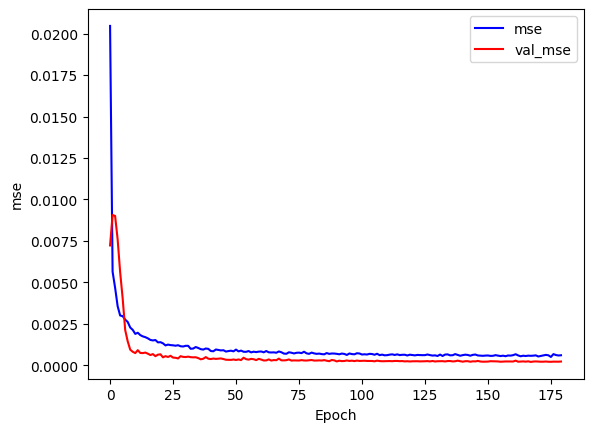

In [30]:
plt.plot(history.history["mse"], 'b', label="mse")
plt.plot(history.history["val_mse"], 'r', label="val_mse")
plt.ylabel("mse")
plt.xlabel("Epoch")
plt.legend()
plt.show()

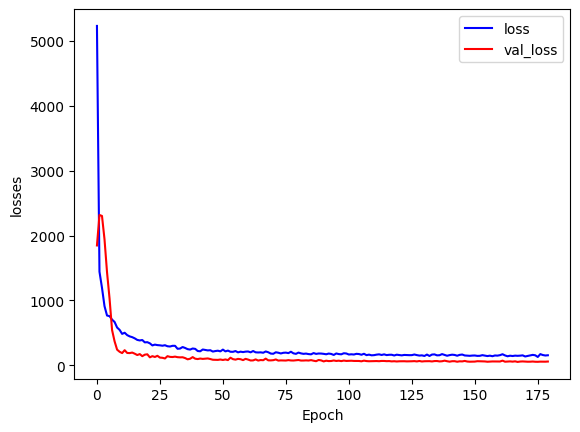

In [31]:
plt.plot(history.history["loss"], 'b', label="loss")
plt.plot(history.history["val_loss"], 'r', label="val_loss")
plt.ylabel("losses")
plt.xlabel("Epoch")
plt.legend()
plt.show()

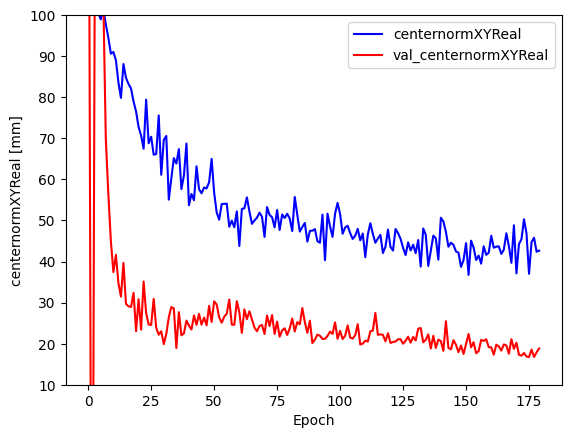

In [32]:
plt.plot(history.history["centernormXYReal"], 'b', label="centernormXYReal")
plt.plot(history.history["val_centernormXYReal"], 'r', label="val_centernormXYReal")
plt.ylabel("centernormXYReal [mm]")
plt.xlabel("Epoch")
plt.ylim([10, 100])
plt.legend()
plt.show()

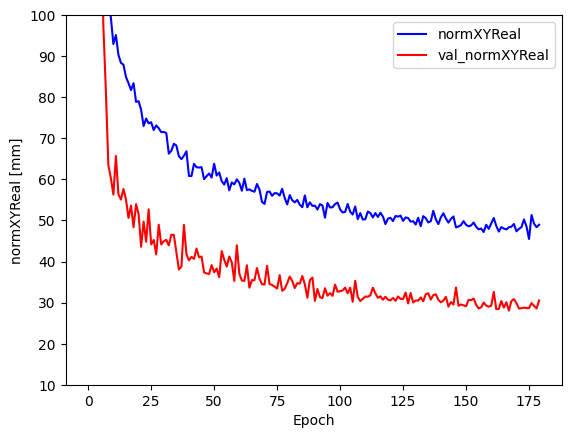

In [33]:
plt.plot(history.history["normXYReal"], 'b', label="normXYReal")
plt.plot(history.history["val_normXYReal"], 'r', label="val_normXYReal")
plt.ylabel("normXYReal [mm]")
plt.xlabel("Epoch")
plt.ylim([10, 100])
plt.legend()
plt.show()

In [148]:
results = model.evaluate(test_data, test_labels)
dict(zip(model.metrics_names, results))

2023-10-17 19:34:09.697230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 8s 73ms/step - loss: 354.2314 - mse: 0.0014 - centernormXYReal: 76.1281 - normXYReal: 66.5719 - mseXYReal: 3722.6479 - maeXYReal: 41.8266 - rmseXYReal: 61.0135


{'loss': 354.2314147949219,
 'mse': 0.00136197404935956,
 'centernormXYReal': 76.12806701660156,
 'normXYReal': 66.57193756103516,
 'mseXYReal': 3722.64794921875,
 'maeXYReal': 41.826568603515625,
 'rmseXYReal': 61.01350784301758}